<a href="https://colab.research.google.com/github/mascalmeida/colab_classes/blob/main/codes/training_approaches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset validation vs LOOCV vs CV (<a href="http://www.gamma.ufba.br/">Gamma</a>)

Docente: Karla Esquerre (<a href="https://github.com/kesquerre">@kesquerre</a>)

Facilitador: Lucas Mascarenhas (<a href="https://github.com/mascalmeida">@mascalmeida</a>)

In [ ]:
# Pacotes e Definindo a semente
## Manipulação e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Modelagem
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

## Setando a semente
seed = 2021

In [ ]:
# Importando dados
data = pd.read_csv('https://raw.githubusercontent.com/mascalmeida/colab_classes/main/datasets/water_potability.csv')
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
# Identificando problemas
## Valores faltantes
nas = pd.DataFrame(data.isna().sum()).reset_index().rename(columns={"index": "variavel", 0: "nas"})
nas['nas_100'] = 100 - ((abs(len(data) - nas['nas'])/len(data))*100)
print('Quantidade de valores faltantes')
print(nas)
## Dados desbalanceados
print('\n\n')
print('Balanceamento dos dados')
print(data['Potability'].value_counts())

Quantidade de valores faltantes
          variavel  nas    nas_100
0               ph  491  14.987790
1         Hardness    0   0.000000
2           Solids    0   0.000000
3      Chloramines    0   0.000000
4          Sulfate  781  23.840049
5     Conductivity    0   0.000000
6   Organic_carbon    0   0.000000
7  Trihalomethanes  162   4.945055
8        Turbidity    0   0.000000
9       Potability    0   0.000000



Balanceamento dos dados
0    1998
1    1278
Name: Potability, dtype: int64


In [ ]:
# Lidando com os valores faltantes considerando o desbalanceamento
data_novo = data.loc[~((data['Potability'] == 0) & ((data['ph'].isna()) | (data['Sulfate'].isna()) | (data['Trihalomethanes'].isna()))), :].\
                  dropna(subset=['Trihalomethanes']).\
                  interpolate(method='linear', limit_direction='backward').\
                  dropna()
# Conferindo
## Valores faltantes
nas = pd.DataFrame(data_novo.isna().sum()).reset_index().rename(columns={"index": "variavel", 0: "nas"})
nas['nas_100'] = 100 - ((abs(len(data_novo) - nas['nas'])/len(data_novo))*100)
print('Quantidade de valores faltantes')
print(nas)
## Dados desbalanceados
print('\n\n')
print('Balanceamento dos dados')
print(data_novo['Potability'].value_counts())

Quantidade de valores faltantes
          variavel  nas  nas_100
0               ph    0      0.0
1         Hardness    0      0.0
2           Solids    0      0.0
3      Chloramines    0      0.0
4          Sulfate    0      0.0
5     Conductivity    0      0.0
6   Organic_carbon    0      0.0
7  Trihalomethanes    0      0.0
8        Turbidity    0      0.0
9       Potability    0      0.0



Balanceamento dos dados
1    1220
0    1200
Name: Potability, dtype: int64


In [ ]:
# Pré processamento
## Reservando dados para validação do modelo
data_modelo, test = train_test_split(data_novo, 
                                     stratify=data_novo['Potability'], 
                                     random_state = seed, 
                                     test_size = 0.1)
## Definindo entradas e saída
### Saída
y = data_modelo['Potability']
### Entradas
x = data_modelo.drop(columns=['Potability'])

## Validation approach
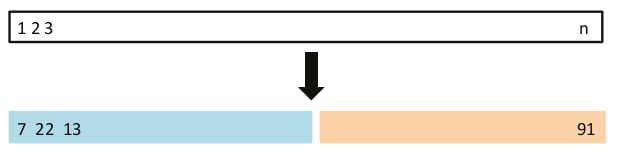

Avaliando o modelo -----------------------
               precision    recall  f1-score   support

           0       0.55      0.53      0.54       216
           1       0.55      0.56      0.56       220

    accuracy                           0.55       436
   macro avg       0.55      0.55      0.55       436
weighted avg       0.55      0.55      0.55       436



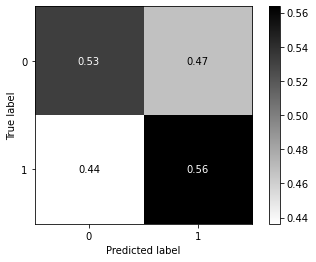

In [ ]:
# Pré processamento 2
## Dividindo o dataset em treino e validação
x_train, x_valid, y_train, y_valid = train_test_split(x, y, 
                                                      stratify=y, 
                                                      random_state = seed, 
                                                      test_size = 0.20)

# Treinando o modelo (árvore de decisão)
modelo = DecisionTreeClassifier(random_state = seed)
modelo = modelo.fit(x_train, y_train)
modelo1 = modelo
# Predição e avaliação do modelo
y_valid_pred = modelo.predict(x_valid)
## print classification report
print('Avaliando o modelo -----------------------\n', classification_report(y_valid, y_valid_pred))
##Confusion Matrix
plot_confusion_matrix(modelo, x_valid, y_valid, normalize='true', cmap='binary')
plt.show();

## Cross-validation

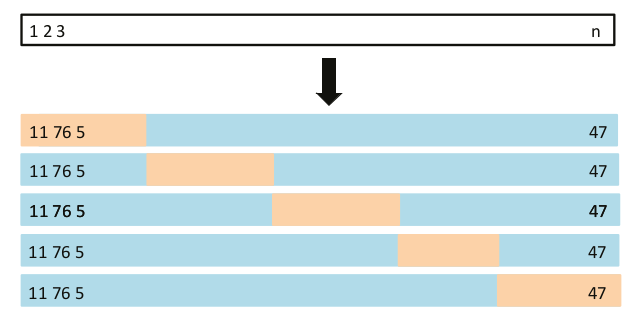

In [ ]:
# Modelagem
from sklearn.model_selection import GridSearchCV
# Importando o Make Scorer
from sklearn.metrics import make_scorer
# Importando os módulos de cálculo de métricas
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

# Criando um dicionário com as métricas que desejo calcular.
meus_scores = {'accuracy' :make_scorer(accuracy_score),
               'recall'   :make_scorer(recall_score),
               'precision':make_scorer(precision_score),
               'f1'       :make_scorer(fbeta_score, beta = 1)}


# Definindo o 'K' para o K-Fold
k = 5
## Defining parameter range to grid search
param_grid = [{'splitter': ['best', 'random']}]
# Treinando o modelo (árvore de decisão)
clf = DecisionTreeClassifier(random_state = seed)
modelo = GridSearchCV(estimator=clf,
                      param_grid=param_grid,
                      scoring = meus_scores,
                      refit = 'f1',
                      cv=k)
modelo.fit(x, y);
modelo2 = modelo
# Results
print('Model =', modelo.best_params_)
display(pd.DataFrame(modelo.cv_results_)[['params', 'mean_test_accuracy','mean_test_precision','mean_test_recall','mean_test_f1']])

Model = {'splitter': 'best'}


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,{'splitter': 'best'},0.561981,0.564843,0.566488,0.565572
1,{'splitter': 'random'},0.556911,0.561438,0.556430,0.558771


In [ ]:
# Criando um dicionário com as métricas que desejo calcular.
meus_scores = {'accuracy' :make_scorer(accuracy_score),
               'recall'   :make_scorer(recall_score),
               'precision':make_scorer(precision_score),
               'f1'       :make_scorer(fbeta_score, beta = 1)}


# Definindo o 'K' para o K-Fold
k = 10
## Defining parameter range to grid search
param_grid = [{'splitter': ['best', 'random']}]
# Treinando o modelo (árvore de decisão)
clf = DecisionTreeClassifier(random_state = seed)
modelo = GridSearchCV(estimator=clf,
                      param_grid=param_grid,
                      scoring = meus_scores,
                      refit = 'f1',
                      cv=k)
modelo.fit(x, y);
modelo10 = modelo
# Results
print('Model =', modelo.best_params_)
display(pd.DataFrame(modelo.cv_results_)[['params', 'mean_test_accuracy','mean_test_precision','mean_test_recall','mean_test_f1']])

Model = {'splitter': 'best'}


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,{'splitter': 'best'},0.569776,0.573132,0.571802,0.571021
1,{'splitter': 'random'},0.554196,0.559937,0.545471,0.551790


In [ ]:
print(y.value_counts())

1    1098
0    1080
Name: Potability, dtype: int64


In [ ]:
# Criando um dicionário com as métricas que desejo calcular.
meus_scores = {'accuracy' :make_scorer(accuracy_score),
               'recall'   :make_scorer(recall_score),
               'precision':make_scorer(precision_score),
               'f1'       :make_scorer(fbeta_score, beta = 1)}


# Definindo o 'K' para o K-Fold
k = 1080
## Defining parameter range to grid search
param_grid = [{'splitter': ['best', 'random']}]
# Treinando o modelo (árvore de decisão)
clf = DecisionTreeClassifier(random_state = seed)
modelo = GridSearchCV(estimator=clf,
                      param_grid=param_grid,
                      scoring = meus_scores,
                      refit = 'f1',
                      cv=k)
modelo.fit(x, y);
LOOCV = modelo
# Results
print('Model =', modelo.best_params_)
display(pd.DataFrame(modelo.cv_results_)[['params', 'mean_test_accuracy','mean_test_precision','mean_test_recall','mean_test_f1']])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

Model = {'splitter': 'best'}


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,{'splitter': 'best'},0.581327,0.462654,0.583333,0.502346
1,{'splitter': 'random'},0.550463,0.434259,0.556019,0.473981


In [ ]:
## Definindo entradas e saída
### Saída
y_test = test['Potability']
### Entradas
x_test = test.drop(columns=['Potability'])

Avaliando o modelo 1 -----------------------
               precision    recall  f1-score   support

           0       0.55      0.60      0.57       120
           1       0.57      0.52      0.54       122

    accuracy                           0.56       242
   macro avg       0.56      0.56      0.56       242
weighted avg       0.56      0.56      0.56       242



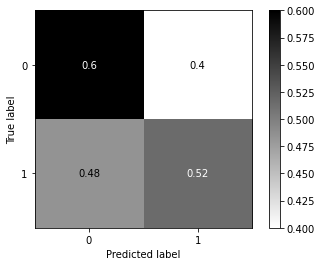

In [ ]:
# Predição e avaliação do modelo 1
y1 = modelo1.predict(x_test)
## print classification report
print('Avaliando o modelo 1 -----------------------\n', classification_report(y_test, y1))
##Confusion Matrix
plot_confusion_matrix(modelo1, x_test, y_test, normalize='true', cmap='binary')
plt.show();

Avaliando o modelo 2 -----------------------
               precision    recall  f1-score   support

           0       0.61      0.54      0.58       120
           1       0.60      0.66      0.63       122

    accuracy                           0.60       242
   macro avg       0.60      0.60      0.60       242
weighted avg       0.60      0.60      0.60       242



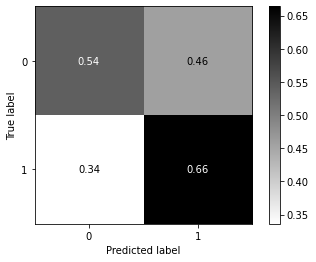

In [ ]:
# Predição e avaliação do modelo 2
y2 = modelo2.predict(x_test)
## print classification report
print('Avaliando o modelo 2 -----------------------\n', classification_report(y_test, y2))
##Confusion Matrix
plot_confusion_matrix(modelo2, x_test, y_test, normalize='true', cmap='binary')
plt.show();

Avaliando o modelo 10 -----------------------
               precision    recall  f1-score   support

           0       0.61      0.54      0.58       120
           1       0.60      0.66      0.63       122

    accuracy                           0.60       242
   macro avg       0.60      0.60      0.60       242
weighted avg       0.60      0.60      0.60       242



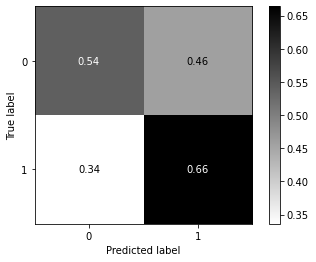

In [ ]:
# Predição e avaliação do modelo 10
y10 = modelo10.predict(x_test)
## print classification report
print('Avaliando o modelo 10 -----------------------\n', classification_report(y_test, y10))
##Confusion Matrix
plot_confusion_matrix(modelo10, x_test, y_test, normalize='true', cmap='binary')
plt.show();

Avaliando o LOOCV -----------------------
               precision    recall  f1-score   support

           0       0.61      0.54      0.58       120
           1       0.60      0.66      0.63       122

    accuracy                           0.60       242
   macro avg       0.60      0.60      0.60       242
weighted avg       0.60      0.60      0.60       242



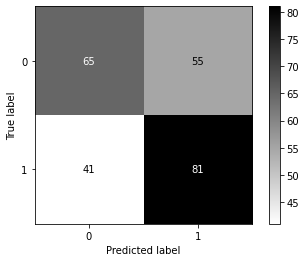

In [ ]:
# Predição e avaliação do modelo LOOCV
yLOOCV = LOOCV.predict(x_test)
## print classification report
print('Avaliando o LOOCV -----------------------\n', classification_report(y_test, yLOOCV))
##Confusion Matrix
plot_confusion_matrix(LOOCV, x_test, y_test, normalize=None, cmap='binary')
plt.show();

**REFERÊNCIAS**


*   [Kaggle - Water Quality](https://www.kaggle.com/adityakadiwal/water-potability)
*   List item

